# Data Mining Project 
Developed by Gil Teixeira, 88194.

The paper selected is named:
### Analyzing the Performance of Stroke Prediction using ML Classification Algorithms [1]

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
print("Using pandas %s version" % pd.__version__)
print("Using numpy %s version" % np.__version__)
print("Using sklearn %s version" % sk.__version__)



Using pandas 1.3.4 version
Using numpy 1.20.3 version
Using sklearn 0.24.2 version


First the data must be PreProcessed!
We drop the id column as it doesn't make any diference for the models performance.
Then we must substitute NaN (null) entries with the class means in this case, as pointed by the paper, exclusively the column bmi.
Finally we must encode the 5 non-numerical variables to numeric ones!

In [26]:
dataset = pd.read_csv('./dataset/healthcare-dataset-stroke-data.csv')
df_dataset = pd.DataFrame(data=dataset)

#Dropping 'id' column
df_dataset.drop('id', axis=1, inplace=True)

#Substituting NaN (null) entries with the bmi means
df_dataset['bmi'].fillna(df_dataset['bmi'].mean(), inplace=True)
categoric_vars = ["gender","ever_married","work_type","Residence_type","smoking_status"]
#Encoding of non-numerical variables!
for categoric_var in categoric_vars:
    df_dataset[categoric_var].replace({label: int(idx) for idx, label in enumerate(np.unique(df_dataset[categoric_var]))}, inplace=True)

print(df_dataset.head())

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   
2       1  80.0             0              1             1          2   
3       0  49.0             0              0             1          2   
4       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level        bmi  smoking_status  stroke  
0               1             228.69  36.600000               1       1  
1               0             202.21  28.893237               2       1  
2               0             105.92  32.500000               2       1  
3               1             171.23  34.400000               3       1  
4               0             174.12  24.000000               2       1  


As noted by the authors the data is highly imbalanced!
As shown in the plot bellow there are way more entries for no risk of stroke then for having risk of one. Of the 5110 entries only 249 correspond to patients with risk of stroke!

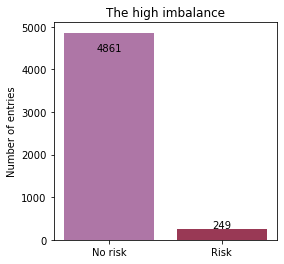

In [27]:
def plot_imbalance(dataset):
        no_risk_count = dataset["stroke"].loc[dataset["stroke"] == 0].count()
        risk_count = dataset["stroke"].loc[dataset["stroke"] == 1].count()
        bar_data = [no_risk_count, risk_count]
        plt.figure(figsize=(4,4))
        bar_plot = plt.bar(["No risk", "Risk"], bar_data, color=['#AE76A6', '#993955'])
        for idx,rect in enumerate(bar_plot):
                height = rect.get_height()
                plt.text(rect.get_x() + rect.get_width()/2., 0.9*height,
                        bar_data[idx],
                        ha='center', va='bottom', rotation=0)
        plt.title("The high imbalance")
        plt.ylabel("Number of entries")
        plt.show()
plot_imbalance(df_dataset)

To handle this imbalance and as not to produce models with very high accuracy but with very poor results in other very important metrics that will be used to compare the multiple models addressed!
The technique used in the paper references '7 Techniques to Handle Imbalanced Data – Kdnuggets' and the majority class is undersampled to match the minority class

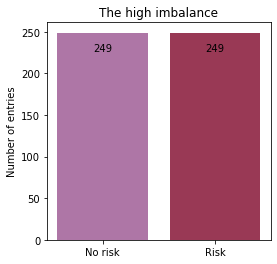

In [28]:
df_dataset.loc[df_dataset["stroke"] == 0] = df_dataset.loc[df_dataset["stroke"] == 0].sample(249)
df_dataset.dropna(inplace=True)
df_dataset.reset_index(drop=True, inplace=True)
plot_imbalance(df_dataset)

Since our prediction target is boolean it makes a lot of sense to try first the logistic regression!
The results for the multiple metrics throughout this notebook will change per each run since the train and test sets have different samples!
## Machine learning algorithms 
Before modeling we must separate our data intro training and testing data sets!
Furthermore some useful functions that will be reused by every model are defined here.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df_dataset.drop(
    'stroke', axis=1), df_dataset['stroke'].astype('int'), test_size=0.2)
stats = {}
# useful functions for the model stats!


def print_stats(cls_name, y_test, prediction):
    print(cls_name + " metrics:")
    stats[cls_name] = {
        "accuracy":  metrics.accuracy_score(y_test, prediction),
        "precision":  metrics.average_precision_score(y_test, prediction),
        "recall":  metrics.recall_score(y_test, prediction),
        "f1_score": metrics.f1_score(y_test, prediction)
    }
    print("Accuracy: " + str(stats[cls_name]["accuracy"]))
    print("Precision: " + str(stats[cls_name]["precision"]))
    print("Recall: " + str(stats[cls_name]["recall"]))
    print("F1 score: " + str(stats[cls_name]["f1_score"]))


def show_roc_curve(cls, x_test, y_test):
    probs = cls.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("Receiver operating characteristic (ROC) curve:")
    metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()


### Logistic Regression

Logistic Regression metrics:
Accuracy: 0.8
Precision: 0.6850925486473659
Recall: 0.8372093023255814
F1 score: 0.782608695652174
Receiver operating characteristic (ROC) curve:


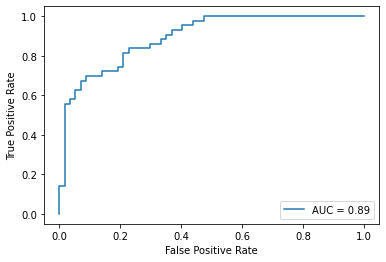

In [30]:
logistic_classifier = LogisticRegression(max_iter=1000).fit(x_train, y_train)
prediction = logistic_classifier.predict(x_test)
print_stats("Logistic Regression", y_test, prediction)
show_roc_curve(logistic_classifier, x_test, y_test)

### Decision Tree Classification

Decision Tree metrics:
Accuracy: 0.61
Precision: 0.5021877691645134
Recall: 0.6744186046511628
F1 score: 0.597938144329897
Receiver operating characteristic (ROC) curve:


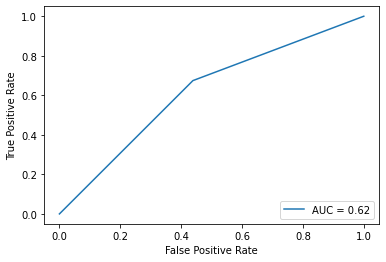

In [31]:
decision_tree_cls = tree.DecisionTreeClassifier().fit(x_train, y_train)
prediction = decision_tree_cls.predict(x_test)
print_stats("Decision Tree", y_test, prediction)
show_roc_curve(decision_tree_cls, x_test, y_test)

### Random Forest Classification

Random Forest metrics:
Accuracy: 0.78
Precision: 0.6607020623080299
Recall: 0.8604651162790697
F1 score: 0.7708333333333334
Receiver operating characteristic (ROC) curve:


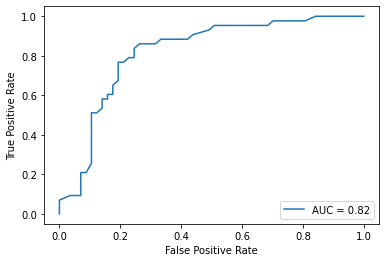

In [32]:
random_forest_cls = RandomForestClassifier().fit(x_train, y_train)
prediction = random_forest_cls.predict(x_test)
print_stats("Random Forest", y_test, prediction)
show_roc_curve(random_forest_cls, x_test, y_test)

### K-nearest neighbors

K-nearest neighbors metrics:
Accuracy: 0.71
Precision: 0.5870304114490161
Recall: 0.7674418604651163
F1 score: 0.6947368421052632
Receiver operating characteristic (ROC) curve:


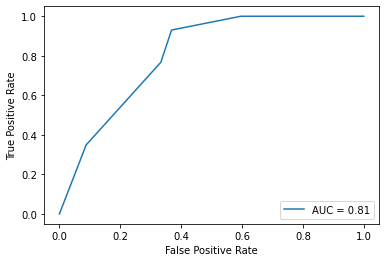

In [33]:
k_nearest_neighbors_cls = KNeighborsClassifier().fit(x_train, y_train)
prediction = k_nearest_neighbors_cls.predict(x_test)
print_stats("K-nearest neighbors", y_test, prediction)
show_roc_curve(k_nearest_neighbors_cls, x_test, y_test)

### Support Vector Machine

SVM metrics:
Accuracy: 0.79
Precision: 0.6727906976744186
Recall: 0.8372093023255814
F1 score: 0.7741935483870969
Receiver operating characteristic (ROC) curve:


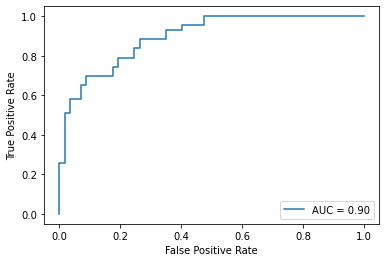

In [34]:
svm_cls = clf = SVC(kernel='linear', probability=True).fit(x_train, y_train)
prediction = svm_cls.predict(x_test)
print_stats("SVM", y_test, prediction)
show_roc_curve(svm_cls, x_test, y_test)

### Naive Bayes

Naive Bayes metrics:
Accuracy: 0.76
Precision: 0.6386473659231133
Recall: 0.7906976744186046
F1 score: 0.7391304347826086
Receiver operating characteristic (ROC) curve:


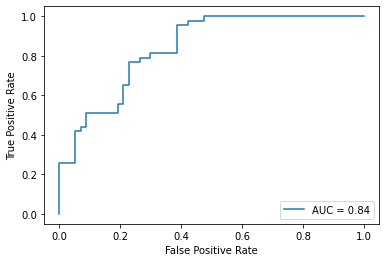

In [35]:
naive_bayes_cls = clf = GaussianNB().fit(x_train, y_train)
prediction = naive_bayes_cls.predict(x_test)
print_stats("Naive Bayes", y_test, prediction)
show_roc_curve(naive_bayes_cls, x_test, y_test)

## Results
Following the tests done and with the statistcs already filled, the multiple metrics are compared in bar plots by the same order used before: accuracy, precision, recall and f1 score!

In [36]:
def plot_stat(stat_name):
    colot_pallet = ["#935ba4", "#e57d25", "#f09b1e", "#3a96d1", "#4db86e", "#efc319"]
    stat_name_sorted_stats = dict(sorted(stats.items(),key=lambda item:item[1][stat_name], reverse=True))
    plt.figure(figsize = (10, 8)) 
    stat_name_sorted_values = [item[stat_name]*100 for item in stat_name_sorted_stats.values()]
    bar_plot = plt.bar(stat_name_sorted_stats.keys(), stat_name_sorted_values, color=colot_pallet,  width=0.6) 
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 0.95*height,
                "{:.1f}%".format(stat_name_sorted_values[idx]),
                ha='center', va='bottom', rotation=0)
    plt.ylabel(stat_name.title() + " in %") 
    plt.title("Models ranked by " + stat_name + "!") 
    plt.show() 

This function serves to plot any stat!

### Accuracy

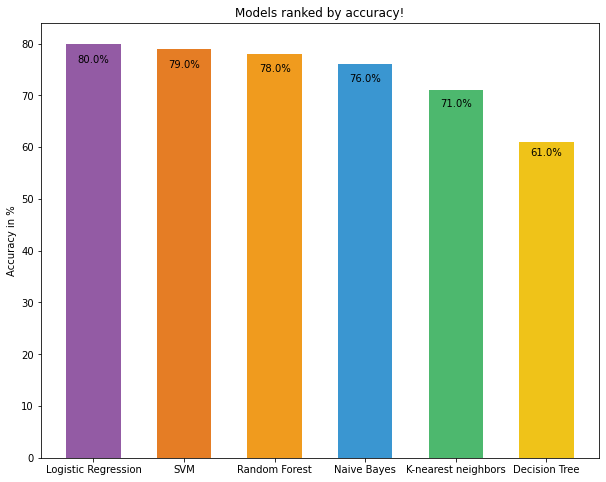

In [37]:
plot_stat("accuracy")


### Precision

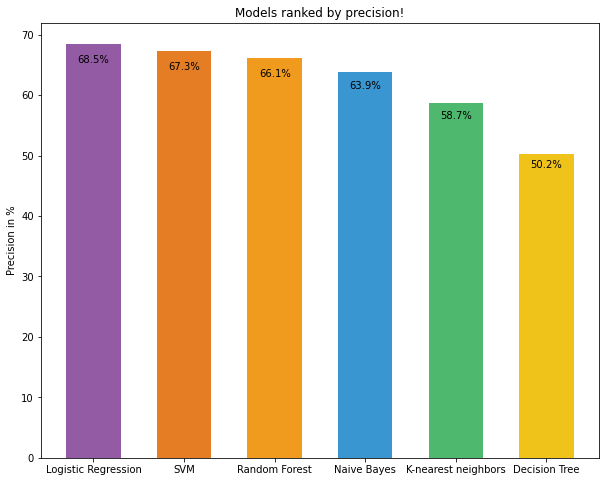

In [38]:
plot_stat("precision")

### Recall

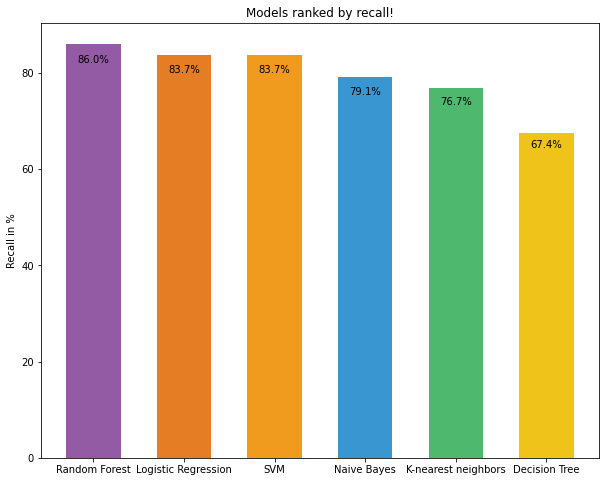

In [39]:
plot_stat("recall")

### F1 score

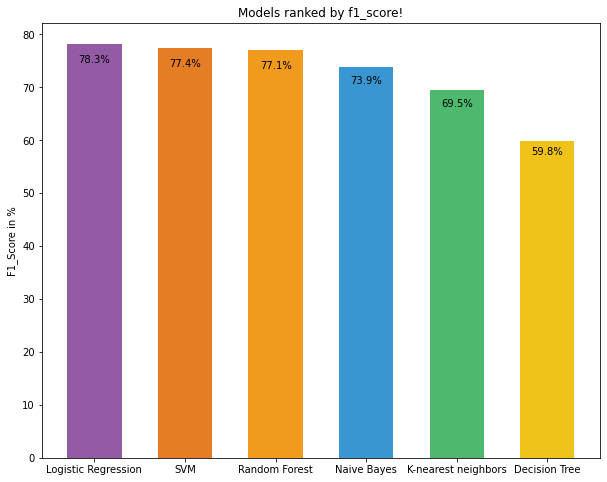

In [40]:
plot_stat("f1_score")

## Conclusions
The results differ very little from the ones suggested in the paper!
As so the conclusions tens to be the same... a ML algorithm trained on image datasets would probably lead to a better model for stroke prediction, though with some of these algorithms, on this dataset, we do get fairly good results! 

## References
[1] Accessed 20th of February, 2022 - https://thesai.org/Downloads/Volume12No6/Paper_62-Analyzing_the_Performance_of_Stroke_Prediction.pdf